In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


In [2]:
from sklearn.metrics import confusion_matrix,plot_confusion_matrix,classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier 
from sklearn.metrics import precision_recall_fscore_support,accuracy_score

In [3]:
#Function to check the performance metric
def evaluate_model(model, X_train, y_train, X_test, y_test):
    _ = model.fit(X_train, y_train)
    print("Precision-Recall report=" , precision_recall_fscore_support(y_test, model.predict(X_test), average='weighted'))
    print("Train Accuracy Score=",accuracy_score(y_train,model.predict(X_train)))
    print("Test Accuracy Score=",accuracy_score(y_test,model.predict(X_test)))
  

In [4]:
#Load Australian credit approval dataset in pandas dataframe from .dat file
credit_df = pd.read_table("../week_16/australian.dat", sep=" ",header=None)
columns_list = ['A1', 'A2', 'A3', 'A4','A5', 'A6', 'A7', 'A8','A9', 'A10', 'A11', 'A12','A13', 'A14', 'A15']
credit_df.columns = columns_list 
credit_df

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15
0,1,22.08,11.460,2,4,4,1.585,0,0,0,1,2,100,1213,0
1,0,22.67,7.000,2,8,4,0.165,0,0,0,0,2,160,1,0
2,0,29.58,1.750,1,4,4,1.250,0,0,0,1,2,280,1,0
3,0,21.67,11.500,1,5,3,0.000,1,1,11,1,2,0,1,1
4,1,20.17,8.170,2,6,4,1.960,1,1,14,0,2,60,159,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
685,1,31.57,10.500,2,14,4,6.500,1,0,0,0,2,0,1,1
686,1,20.67,0.415,2,8,4,0.125,0,0,0,0,2,0,45,0
687,0,18.83,9.540,2,6,4,0.085,1,0,0,0,2,100,1,1
688,0,27.42,14.500,2,14,8,3.085,1,1,1,0,2,120,12,1


## Check correlation using heatmap

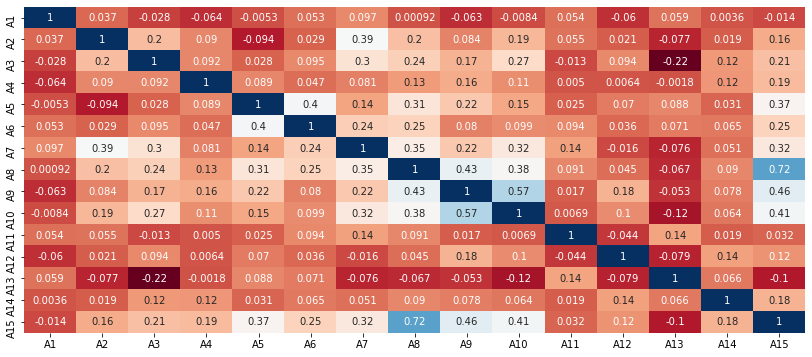

In [5]:
#Check heatmap
plt.figure(figsize=(14,6))
sns.heatmap(credit_df.corr(), annot=True, cbar=False, cmap='RdBu')
plt.show()

#A8 has higher correlation(0.72) with target variable A15

## Finding and removing outliers

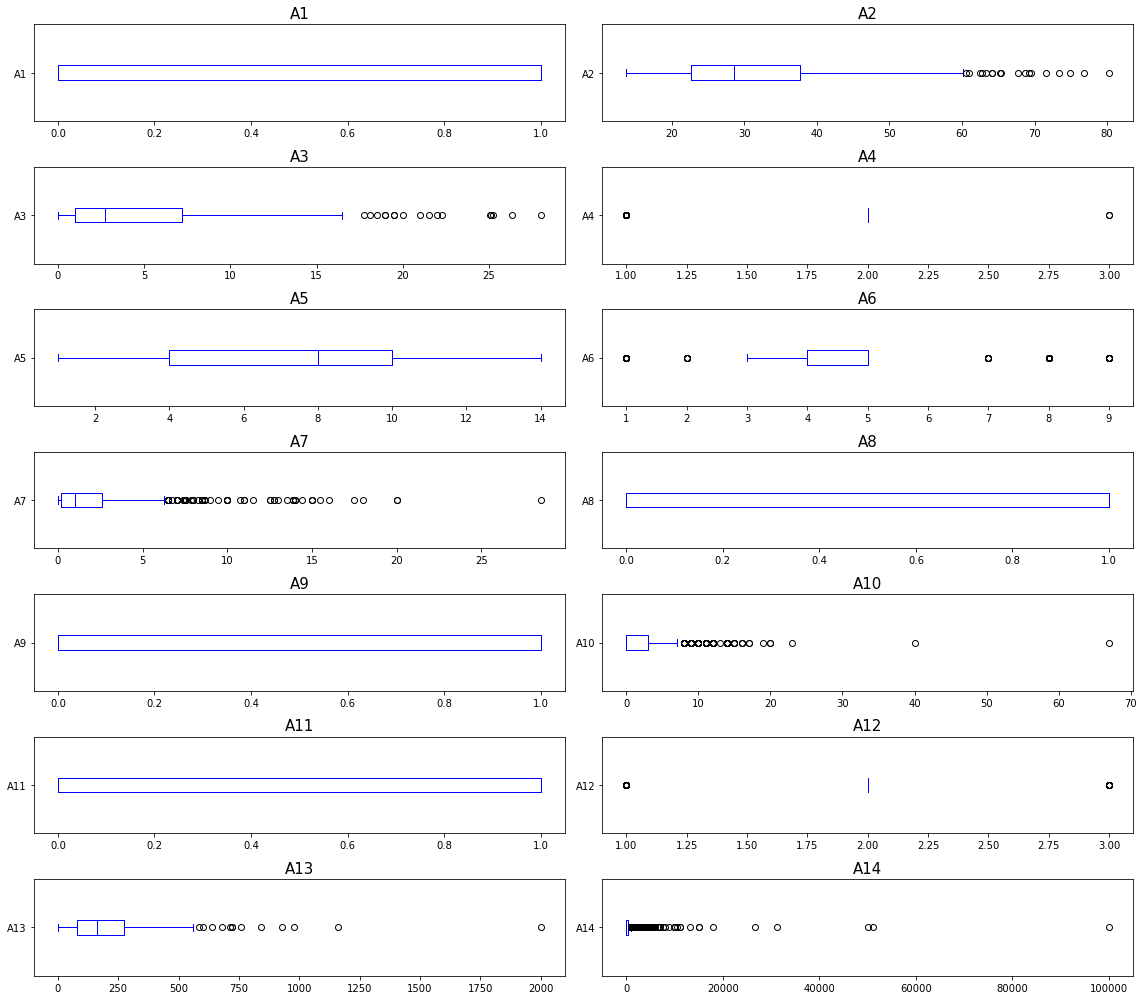

In [6]:
numerical_features = ['A1', 'A2', 'A3', 'A4','A5', 'A6', 'A7', 'A8','A9', 'A10', 'A11', 'A12','A13', 'A14']
target = 'A15'


fig, axes = plt.subplots(7,2,figsize=(16, 14))
axes = np.ravel(axes)

for i, c in enumerate(numerical_features):
    hist = credit_df[c].plot(kind = 'box', ax=axes[i],color='blue', vert=False)
    axes[i].set_title(c, fontsize=15)
    
plt.tight_layout()
plt.show()


## Analysis of outliers on performance metric
* Removing outliers for A13 and A14, Decision Tree model improved
    - Precision-Recall report= (0.9222610523228819, 0.9176470588235294, 0.9179219886591442, None)
    - Accuracy Score= 0.9176470588235294
* Removing outliers for A13 and A14, A10 Decision Tree model decreased

In [7]:
#Found outliers in following features
#A2 outliers >=70
#A3 outliers >=25
#A6 outlier <= 2 and >=7
#A7 outliers >=15
#A10 outliers >=20
#A13 outliers >=750
#A14 outlier >=20000


idx = credit_df.loc[credit_df.A13>=750].index
credit_df.drop(idx, inplace=True)

idx = credit_df.loc[credit_df.A14>=20000].index
credit_df.drop(idx, inplace=True)

#idx = credit_df.loc[credit_df.A10>=20].index
#credit_df.drop(idx, inplace=True)

#idx = credit_df.loc[credit_df.A7>=10].index
#credit_df.drop(idx, inplace=True)

#idx = credit_df.loc[credit_df.A3>=20].index
#credit_df.drop(idx, inplace=True)

#idx = credit_df.loc[credit_df.A2>=70].index
#credit_df.drop(idx, inplace=True)

## Recheck correlation after removing outliers

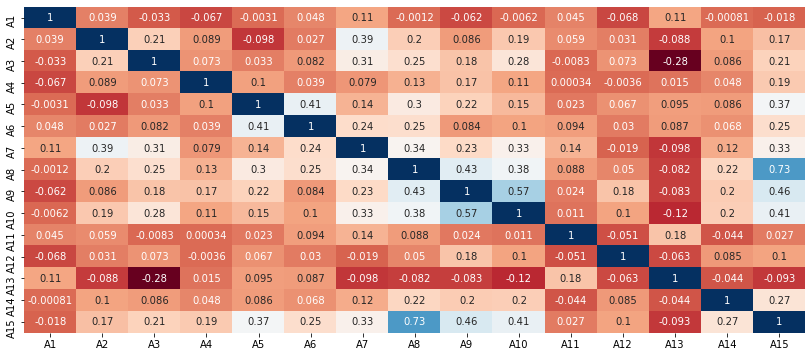

In [8]:
#Check heatmap
plt.figure(figsize=(14,6))
sns.heatmap(credit_df.corr(), annot=True, cbar=False, cmap='RdBu')
plt.show()

#A8 correlation increased to 0.73 with target variable A15

## Feature selection
- Tried using DecisionTreeClassifier as a model to do RFE. The features given by this did't give best peformance metric
- Using LogisticRegression to do RFE and features given by this. Features given before removing outlier and after removing outlier are slightly different.
- Tried Features given by Random Forest feature importances, there was no change in accuracy score


In [9]:
#Feature selection
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
#from sklearn.tree import DecisionTreeClassifier

X2 = credit_df.drop(["A15"],axis=1)
y2 = credit_df["A15"]

model = LogisticRegression()
#model = DecisionTreeClassifier()
#Initializing RFE model
rfe = RFE(model, n_features_to_select=6)

#Transforming data using RFE
X_rfe = rfe.fit_transform(X2,y2)  

#Fitting the data to model
model.fit(X_rfe,y2)
print(rfe.support_)
print(rfe.ranking_)

#Get the feature names where feature supports
rfe_features = X2.columns[np.where(rfe.support_ == True)[0]]
print(rfe_features)

[False False False False  True False False  True  True  True  True  True
 False False]
[2 5 6 8 1 4 3 1 1 1 1 1 7 9]
Index(['A5', 'A8', 'A9', 'A10', 'A11', 'A12'], dtype='object')


In [10]:
#rfe_features = ['A4', 'A5', 'A8', 'A9', 'A11', 'A12'] #Feature selection done using logistic regression model
#rfe_features= ['A2', 'A3', 'A7', 'A8', 'A10', 'A13'] #Feature selection done using DecisionTreeClassifier model

#Set X and y
#X = credit_df[rfe_features]

#Feature importance given by RandomForestModel, the accuracy score remains as tried with 
#logistic regression model feature selection above
X = credit_df[['A5','A8','A9','A10','A11','A12']]
#X = credit_df.drop(["A15"],axis=1)
y = credit_df['A15']


## Check for imbalance

In [11]:
#There is not much of imbalance in dataset
credit_df['A15'].value_counts()

0    378
1    301
Name: A15, dtype: int64

## Train and test split 75%-25%

In [12]:
#Split into train and test
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.25,random_state=42,stratify=y)

## Standardization

In [13]:
#Perform standardization
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_scaler = sc.fit_transform(X_train)
X_test_scaler = sc.fit_transform(X_test)

## Decision tree model

### Trying gridsearch to decide the best hyperparameters for tuning the decision tree model, with 10 folds

In [14]:
#Import GridSeach
from sklearn.model_selection import GridSearchCV


scoring='accuracy' #,'precision_macro','recall_macro']

# Define the grid of hyperparameters 'params_dt'
params_dt = {'max_depth': [3, 4,5,6,7,8,9,10],
             'min_samples_leaf': [0.04, 0.06, 0.08]
             ,'max_features': [0.2, 0.4,0.6, 0.8] 
             ,'min_samples_split': [3,4,5,6]
            }


dtmodel = DecisionTreeClassifier(random_state=42)

# Instantiate a 10-fold CV grid search object 'grid_dt'
grid_dt = GridSearchCV(estimator=dtmodel,param_grid=params_dt,scoring=scoring, cv=10,n_jobs=-1)
# Fit 'grid_dt' to the training data
grid_dt.fit(X_train, y_train)

# Extract best hyperparameters from 'grid_dt'
best_hyperparams = grid_dt.best_params_
print('Best hyerparameters:\n', best_hyperparams)

# Extract best CV score from 'grid_dt'
best_CV_score = grid_dt.best_score_
print('Best CV accuracy', best_CV_score)

Best hyerparameters:
 {'max_depth': 3, 'max_features': 0.8, 'min_samples_leaf': 0.04, 'min_samples_split': 3}
Best CV accuracy 0.8585882352941177


In [15]:
#Decision Tree model
dt_params = {# 'criterion':'mse',
            'max_depth': 10
             ,'min_samples_split': 4
             ,'min_samples_leaf':0.04
             , 'max_features':0.8
            }

#{'max_depth': 4, 'max_features': 0.8, 'min_samples_leaf': 0.04, 'min_samples_split': 3}
#Best CV accuracy 0.8621010638297871

dtmodel = DecisionTreeClassifier(random_state=42,**dt_params)
evaluate_model(dtmodel, X_train, y_train, X_test, y_test)    

Precision-Recall report= (0.9222610523228819, 0.9176470588235294, 0.9179219886591442, None)
Train Accuracy Score= 0.8565815324165029
Test Accuracy Score= 0.9176470588235294


## Random Forest model - Best performing comparin to decision tree and xgboost

In [16]:
#Random Forest Model
# Tried different values for these hyperparamters like n_estimators in [40,90,100,200,500]
# min_samples_split in [3,4,5]
# min_samples_leaf in [0.04,0.05]
# max_depth in [4,5,8,9,10]
# bootstrap in [True,False]
# keeping the hyperparamters that gave highest accuracy score
rf_params = {'n_estimators':90
             ,'min_samples_split': 4
             ,'min_samples_leaf': 0.04
             ,'max_depth': 10
             ,'bootstrap': True
             }

rfmodel = RandomForestClassifier(random_state=42,**rf_params)
evaluate_model(rfmodel, X_train, y_train, X_test, y_test)

Precision-Recall report= (0.9243802872319496, 0.9235294117647059, 0.9236657229736813, None)
Train Accuracy Score= 0.8546168958742633
Test Accuracy Score= 0.9235294117647059


## XGBoost model

In [17]:
#XG boost model
# Tried different values for these hyperparamters like n_estimators in [40,90,100,200,500]
# learning_rate': 0.05, 0.01
# max_depth: 2,5,10
# n_estimators: 90,100,150,250
# keeping the hyperparamters that gave highest accuracy score

xbg_params = {'colsample_bytree': 0.5,
        'learning_rate': 0.05,
        'max_depth': 2,
        'min_child_weight': 1,
        'n_estimators': 150,
        'subsample': 1
    }

xgmodel = XGBClassifier(random_state=42,**xbg_params)
evaluate_model(xgmodel, X_train, y_train, X_test, y_test)

[13:52:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Precision-Recall report= (0.9204181048199555, 0.9176470588235294, 0.9178880582333268, None)
Train Accuracy Score= 0.8546168958742633
Test Accuracy Score= 0.9176470588235294


## Using voting classfier to get the best performance

In [18]:
from sklearn.ensemble import VotingClassifier

classifiers = [('Decision_Tree',dtmodel),('Random_Forest',rfmodel),('XGBoost',xgmodel)]
vc = VotingClassifier(estimators=classifiers)
vc.fit(X_train,y_train)
y_pred_vc = vc.predict(X_test)
evaluate_model(vc, X_train, y_train, X_test, y_test)

[13:52:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:52:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Precision-Recall report= (0.9361105646271888, 0.9352941176470588, 0.9354094579008074, None)
Train Accuracy Score= 0.8565815324165029
Test Accuracy Score= 0.9352941176470588


## ROC curve - checking for Random Forest model 

In [19]:
from sklearn.metrics import roc_curve, roc_auc_score

#ROC Curves are summaries of the trade-off between true positive and false positive rates
#ROC curves are most appropriate for balanced datasets, which is the case in this dataset

y_pred = rfmodel.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test,y_pred )
auc = roc_auc_score(y_test, y_pred)
print(auc)

0.9245614035087719


Text(0, 0.5, 'True Positive Rate')

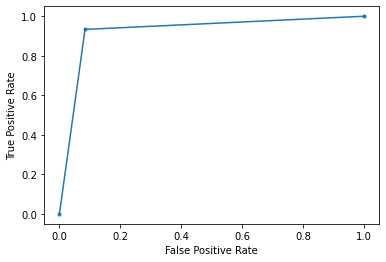

In [20]:
plt.plot(fpr, tpr, marker = '.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

## Feature importance using RandomForest model

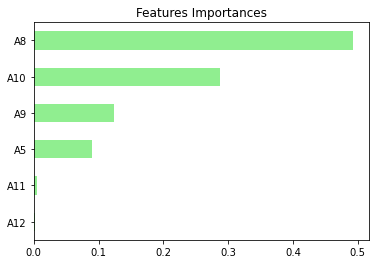

In [21]:
#Went back and tried running the model with the features given by feature importances, there was no change.

# Create a pd.Series of features importances
importances = pd.Series(data=rfmodel.feature_importances_,
                        index= X_train.columns)

# Sort importances
importances_sorted = importances.sort_values()

# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Features Importances')
plt.show()

## Plot confusion matrix and classification report for Random Forest model

In [22]:
y_pred = rfmodel.predict(X_test)
confusion_matrix(y_test,y_pred)

array([[87,  8],
       [ 5, 70]], dtype=int64)

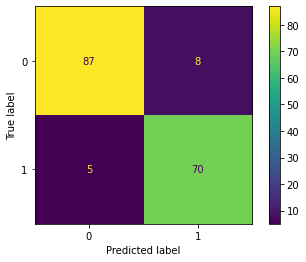

In [23]:
plot_confusion_matrix(rfmodel,X_test,y_test)

In [24]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.92      0.93        95
           1       0.90      0.93      0.92        75

    accuracy                           0.92       170
   macro avg       0.92      0.92      0.92       170
weighted avg       0.92      0.92      0.92       170

